### Imports

In [1]:
# Torch
import torch

# Torch Vision
import torchvision

# Path
from pathlib import Path

# Numpy
import numpy

# Matplot
import matplotlib.pyplot as pp

### Pre-processing

In [2]:
def load(path = '.', transform = torchvision.transforms.ToTensor(), batch = 32, shuffle = True, workers = 5):
    '''
        Load dataset
        
        Parameters
        ----------
        
        path: str
            Folder path
        
        transform: torchvision.transforms
            Transformation function
        
        batch: int
            Number of samples per batch
        
        shuffle: bool
            Data reshuffled at every epoch
        
        workers: int
            Subprocesses to use for data loading
            
        Usage
        -----
        
        >>> load_images(path='../data/train')
        
        Return
        ------
        
        Data Loader object
        
        References
        ----------
        
        https://discuss.pytorch.org/t/how-to-load-png-using-dataloader/17079/2
        
        https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network
        
        https://pytorch.org/docs/stable/torchvision/transforms.html
        
        https://github.com/marvis/pytorch-yolo2/issues/89
        
        https://discuss.pytorch.org/t/how-can-i-load-a-number-of-images/12468/8
    '''
    
    pth = Path(path)
    
    if not pth.exists() or not pth.is_dir():
        raise Exception('Incompatible path or inexistent folder')
    
    return torch.utils.data.DataLoader(
        dataset=torchvision.datasets.ImageFolder(
            root=path,
            transform=transform
        ),
        batch_size=batch,
        shuffle=shuffle,
        num_workers=workers        
    )


def plot(ax, images, cmap='gray', axis=False, title=''):
    '''
        Plot images
        
        Parameters
        ----------
        
        ax: matplotlib.pyplot.subplots
            Guffer to plot images
        
        images: torch.tensor
            Images tensor
            
        cmap: str
            Map of color
        
        axis: bool
            Borders of plots
        
        title: str
            Image title
            
        Usage
        -----
        
        >>> plot(matplotlib.pyplot.subplots(2, 2, figsize=(2, 2)), [[0,0], [1, 1]])
        
        Return
        ------
        
        Buffer loaded
    '''
    
    count = 0
    
    for row in range(ax.shape[0]):
        for col in range(ax.shape[1]):
            ax[row, col].imshow(images[count].numpy().squeeze(), cmap=cmap)
            
            if not axis:
                ax[row, col].axis('off')
            
            if title:
                ax[row, col].set_title(title)
            
            count += 1

In [37]:
# Train data
width, height = 224, 224

transform_train = [
    torchvision.transforms.Resize((height, width)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0,485, 0,456, 0,406), std=(0,229, 0,224, 0,225))
]

# Train 1
train1 = load(
    path='../data/train',
    transform=torchvision.transforms.Compose(transform_train)
)

# Train 2
_train2 = transform_train.copy()

_train2.insert(1, torchvision.transforms.RandomRotation((90, 360)))

train2 = load(
    path='../data/train',
    transform=torchvision.transforms.Compose(_train2)
)

# Train 3
_train3 = transform_train.copy()

_train3.insert(1, torchvision.transforms.ColorJitter(brightness=5, contrast=1, saturation=1))

train3 = load(
    path='../data/train',
    transform=torchvision.transforms.Compose(_train3)
)

# Train 4
_train4 = transform_train.copy()

_train4.insert(1, torchvision.transforms.RandomCrop(size=(height / 2, width / 2)))

train4 = load(
    path='../data/train',
    transform=torchvision.transforms.Compose(_train4)
)

# Train 5
_train5= transform_train.copy()

_train5.insert(1, torchvision.transforms.RandomHorizontalFlip(p=50))

_train5.insert(2, torchvision.transforms.RandomVerticalFlip(p=50))

train5 = load(
    path='../data/train',
    transform=torchvision.transforms.Compose(_train5)
)

# Concat train data
train_vectors = [
    {'title': 'Original', 'data': train1},
    {'title': 'Rotation', 'data': train2},
    {'title': 'Brightness', 'data': train3},
    {'title': 'Crop', 'data': train4},
    {'title': 'Flip', 'data': train5}
]

train = torch.utils.data.ConcatDataset([
    item['data'].dataset for item in train_vectors
])

print(len(train), train.datasets)

32760 [Dataset ImageFolder
    Number of datapoints: 6552
    Root Location: ../data/train
    Transforms (if any): Compose(
                             Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0, 485, 0, 456, 0, 406), std=(0, 229, 0, 224, 0, 225))
                         )
    Target Transforms (if any): None, Dataset ImageFolder
    Number of datapoints: 6552
    Root Location: ../data/train
    Transforms (if any): Compose(
                             Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                             RandomRotation(degrees=(90, 360), resample=False, expand=False)
                             ToTensor()
                             Normalize(mean=(0, 485, 0, 456, 0, 406), std=(0, 229, 0, 224, 0, 225))
                         )
    Target Transforms (if any): None, Dataset ImageFolder
    Number of datapoints: 6552
    Root Location: ../data/tr

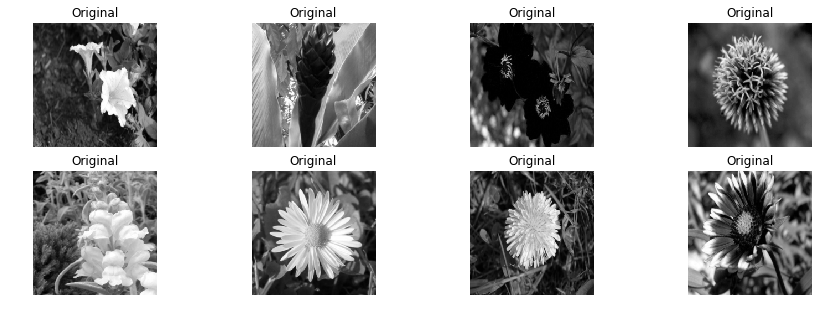

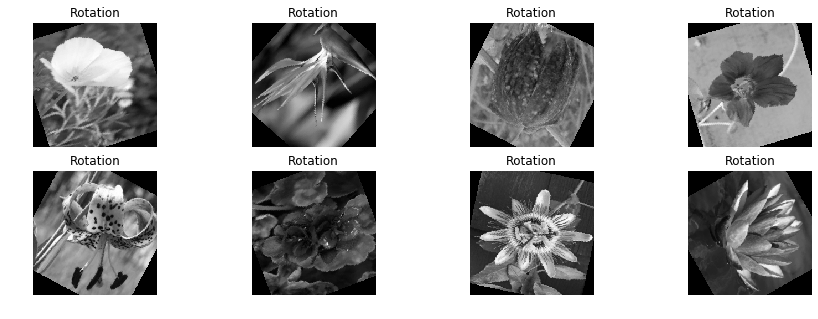

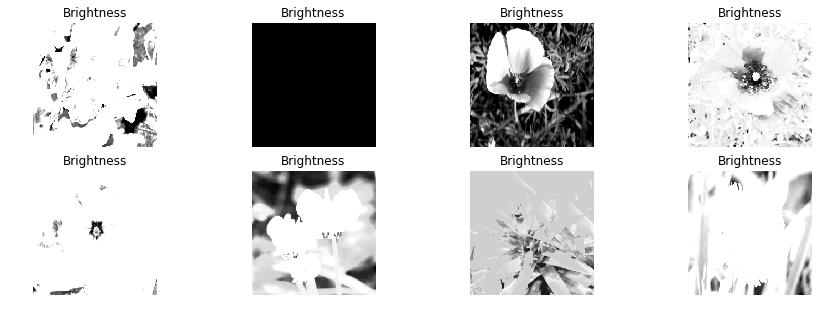

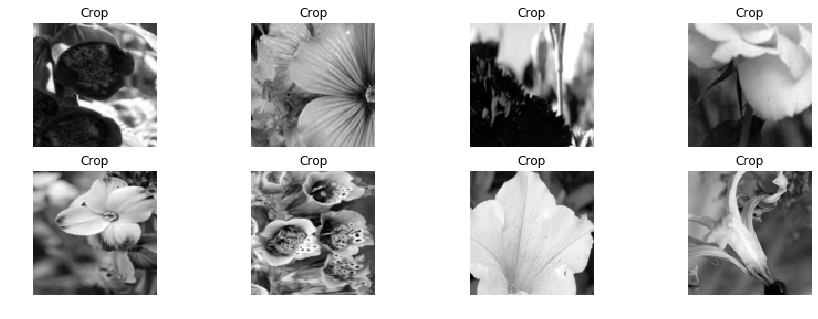

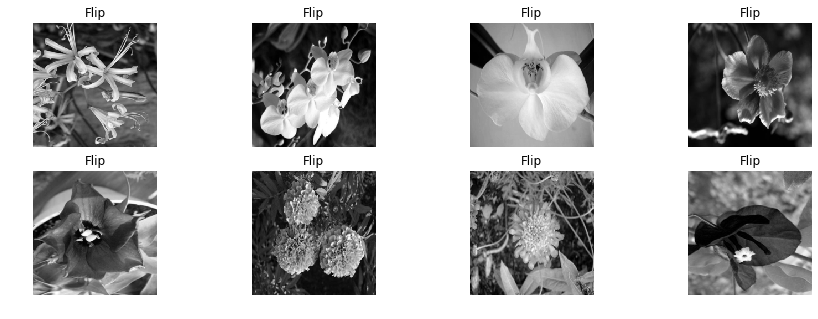

In [38]:
# Plot train data
%matplotlib inline

for item in train_vectors:
    # Get epoch
    images, labels = iter(item['data']).next()

    # Plot images
    fig, ax = pp.subplots(nrows=2, ncols=4, figsize=(15, 5))
    
    plot(ax=ax, images=images[:, 1], cmap='gray', title=item['title'])